In [1]:
import scanpy as sc
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import HSNE.tools as hsne_tl
import HSNE.plotting as hsne_pl

import HUMAP.tools as humap_tl
import HUMAP.plotting as humap_pl

In [2]:
# Load Dataset
print("Loading dataset")
filelocation = r"HSNE/test/datasets/VBh_converted.h5ad"
#filelocation = "C:/Users/xilef/Desktop/Helmholtz/CantoUnstained_converted.h5ad"
adata = anndata.read_h5ad(filelocation)
print(f"Dataset with {len(adata)} cells loaded")

# subsampling (for slow/low memory computers)
#print("subsampling")
#sc.pp.subsample(adata, 0.4)

# removing some channels
for channel in adata.var_names:
    if channel.endswith("-H") or channel == "Time" or channel == "FSC-Width":
        adata.obs[channel]=adata.X[:,adata.var_names == channel]
        adata = adata[:,adata.var_names != channel]

# normalizing
print("Normalizing")
adata.X = np.arcsinh(adata.X / 10)

# calc knn
print("Calculating connectivities")
sc.pp.neighbors(adata, n_neighbors=20)

# calculating louvain clustering of original dataset
print("Calculating louvain clustering")
sc.tl.louvain(adata, resolution=0.5, key_added="louv_05")

print("Done!")

Loading dataset


Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Dataset with 129467 cells loaded
Normalizing
Calculating connectivities
Calculating louvain clustering
Done!


**HUMAP subsampling vs random subsampling**

A dataset will be reduced to a fraction of its original size using the random subsampling method from scanpy and the HUMAP subsampling method.

In [3]:
adata_rand_sub = adata.copy()
adata_humap_sub = adata.copy()

subsampling_factor = 0.005

# random subsampling
print("subsampling randomly")
sc.pp.subsample(adata_rand_sub, subsampling_factor)
sc.pp.neighbors(adata_rand_sub, n_neighbors=20)
print("done")

# humap subsampling
print("subsampling with humap")
humap_tl.humap(adata_humap_sub, subs_mode="factor", factor=subsampling_factor)
adata_humap_sub = adata_humap_sub.uns["HUMAP_scales"][0]

# second scale
adata_humap2_sub = adata.copy()
humap_tl.humap(adata_humap2_sub, subs_mode="factor", n_scales=2, factor=np.sqrt(subsampling_factor))
adata_humap2_sub = adata_humap2_sub.uns["HUMAP_scales"][-1]
print(f"adata_humap2_sub with {adata_humap2_sub.X.shape[0]} cells")
# third scale
adata_humap3_sub = adata.copy()
humap_tl.humap(adata_humap3_sub, subs_mode="factor", n_scales=3, factor=np.power(subsampling_factor, 1/3))
adata_humap3_sub = adata_humap3_sub.uns["HUMAP_scales"][-1]
print(f"adata_humap3_sub with {adata_humap3_sub.X.shape[0]} cells")

print("done")

subsampling randomly
done
subsampling with humap
adata_humap2_sub with 647 cells
adata_humap3_sub with 647 cells
done


Helper function, that shows test results

In [4]:
def printData(anndata_obj):
    # getting clustercounts
    if 'umap' not in anndata_obj.obsm:
        sc.tl.umap(anndata_obj) 
    sc.pl.umap(anndata_obj, color="louv_05", edges=True)
    clustercount = anndata_obj.obs["louv_05"].value_counts()
    plt.bar(np.arange(clustercount.count()), clustercount)
    plt.xticks(np.arange(clustercount.count()))
    
    cellcount = anndata_obj.X.shape[0]
    
    print(f"total cellcount: {cellcount}")
    plt.show()
    sc.tl.paga(anndata_obj, "louv_05")
    sc.pl.paga(anndata_obj)


***The original dataset:***
(not subsampled)

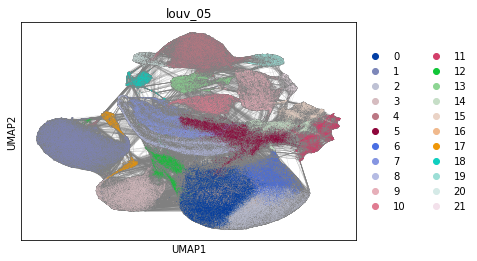

total cellcount: 129467


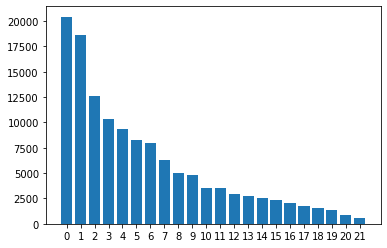

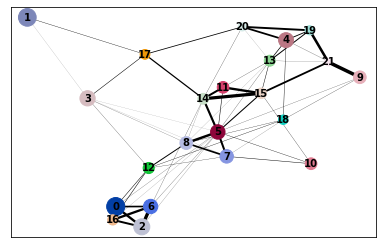

In [5]:
printData(adata)

***Subsampled with the random subsampling method***

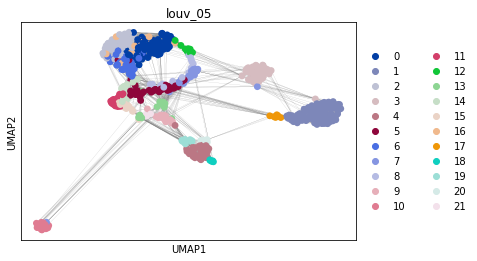

total cellcount: 647


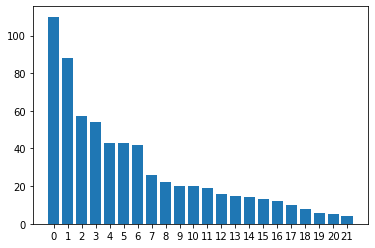

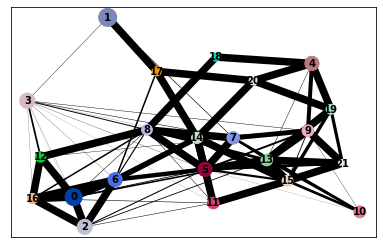

In [6]:
printData(adata_rand_sub)

***Subsampled with the HUMAP subsampling method***

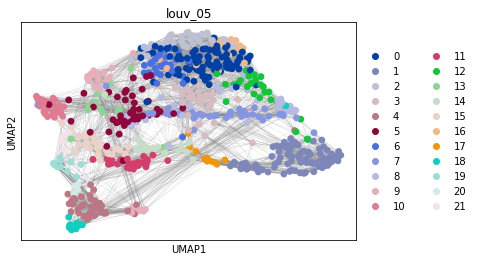

total cellcount: 647


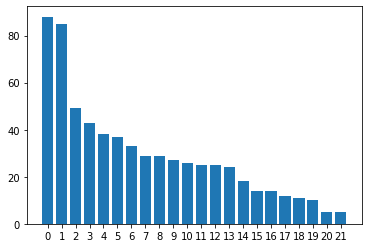

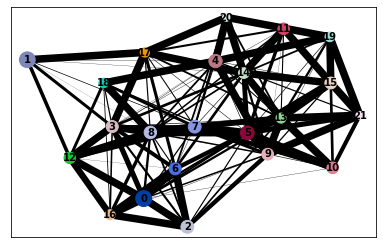

In [7]:
printData(adata_humap_sub)

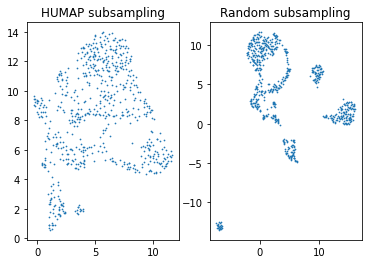

In [8]:
plt.subplot(1, 2, 1)
plt.title('HUMAP subsampling')
plt.scatter(x=adata_humap_sub.obsm['X_umap'][:,0], y=adata_humap_sub.obsm['X_umap'][:,1], s=0.5)
plt.subplot(1, 2, 2)
plt.title('Random subsampling')
plt.scatter(x=adata_rand_sub.obsm['X_umap'][:,0], y=adata_rand_sub.obsm['X_umap'][:,1], s=0.5)
plt.show()

Different subsampling factors:

Subsample factor: 0.2


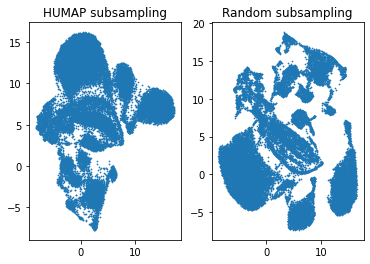

Subsample factor: 0.15


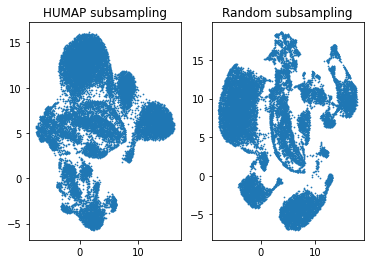

Subsample factor: 0.1


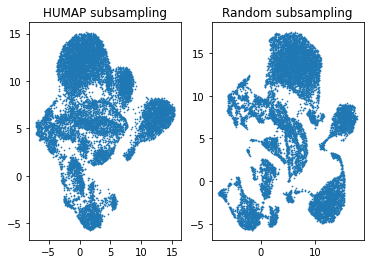

Subsample factor: 0.05


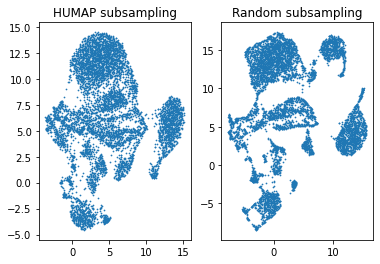

Subsample factor: 0.025


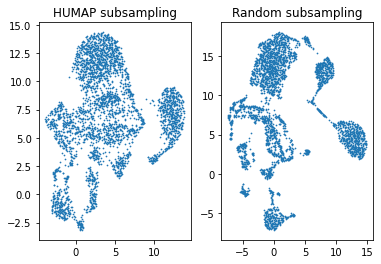

Subsample factor: 0.01


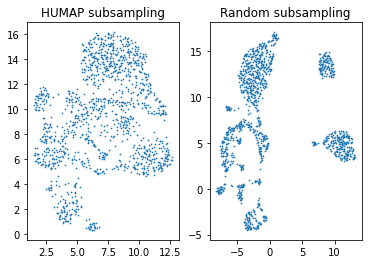

In [9]:
sub_facs = [0.2, 0.15, 0.1, 0.05, 0.025, 0.01]
for sf in sub_facs:
    print(f"Subsample factor: {sf}")
    adata_rand_sub = adata.copy()
    adata_humap_sub = adata.copy()
    
    # random
    sc.pp.subsample(adata_rand_sub, sf)
    sc.pp.neighbors(adata_rand_sub, n_neighbors=20)
    sc.tl.umap(adata_rand_sub)
    
    # humap
    humap_tl.humap(adata_humap_sub, subs_mode="factor", factor=sf)
    adata_humap_sub = adata_humap_sub.uns["HUMAP_scales"][0]
    
    plt.subplot(1, 2, 1)
    plt.title('HUMAP subsampling')
    plt.scatter(x=adata_humap_sub.obsm['X_umap'][:,0], y=adata_humap_sub.obsm['X_umap'][:,1], s=0.5)
    plt.subplot(1, 2, 2)
    plt.title('Random subsampling')
    plt.scatter(x=adata_rand_sub.obsm['X_umap'][:,0], y=adata_rand_sub.obsm['X_umap'][:,1], s=0.5)
    plt.show()


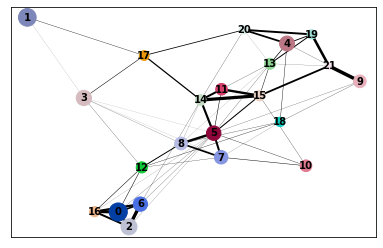

In [10]:
# showing paga
sc.tl.paga(adata, "louv_05")
sc.pl.paga(adata)

#adata.uns["neighbors"]['connectivities']


**Comparing connectivities**

Original vs Random Subsampling

Similarity between subsampled data and original data regarding clustering. The smaller the better.



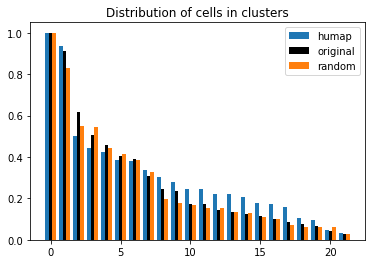

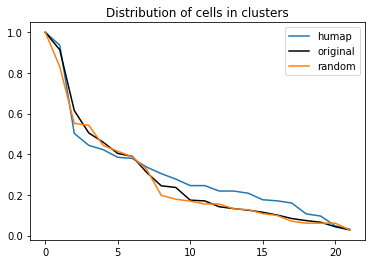

Original vs Random
0.24391952601081793
Original vs Humap
0.359048002066422


In [11]:
print("Similarity between subsampled data and original data regarding clustering. The smaller the better.\n")

orig_clustercount  = adata.obs["louv_05"].value_counts()
orig_clustercount /= np.max(orig_clustercount)

humap_clustercount = adata_humap_sub.obs["louv_05"].value_counts()
humap_clustercount /= np.max(humap_clustercount)

rand_clustercount  = adata_rand_sub.obs["louv_05"].value_counts()
rand_clustercount /= np.max(rand_clustercount)

barwidth = 0.25
plt.bar(np.arange(humap_clustercount.count())-barwidth, humap_clustercount, barwidth , label="humap")
plt.bar(np.arange(orig_clustercount.count()), orig_clustercount, barwidth, label="original", color="black")
plt.bar(np.arange(rand_clustercount.count())+barwidth, rand_clustercount, barwidth, label="random")
plt.legend()
plt.title("Distribution of cells in clusters")
plt.show()

plt.plot(np.arange(humap_clustercount.count()), humap_clustercount , label="humap")
plt.plot(np.arange(orig_clustercount.count()), orig_clustercount, label="original", color="black")
plt.plot(np.arange(rand_clustercount.count()), rand_clustercount, label="random")
plt.legend()
plt.title("Distribution of cells in clusters")
plt.show()


print("Original vs Random")
print(np.linalg.norm(orig_clustercount-rand_clustercount))
print("Original vs Humap")
print(np.linalg.norm(orig_clustercount-humap_clustercount))


In [12]:
print("Similarity between subsampled data and original data regarding connectivities. The smaller the better.\n")

orig_paga = adata.uns['paga']['connectivities'].todense()
orig_paga /= np.max(orig_paga)
print(orig_paga.shape)

humap_paga = adata_humap_sub.uns['paga']['connectivities'].todense()
humap_paga /= np.max(humap_paga)
print(humap_paga.shape)

rand_paga = adata_rand_sub.uns['paga']['connectivities'].todense()
rand_paga /= np.max(rand_paga)
print(rand_paga.shape)

print(np.linalg.norm(orig_paga-humap_paga))

adata.uns['paga']['connectivities']
print(np.linalg.norm(adata.uns['paga']['connectivities'].todense() - adata_humap_sub.uns['paga']['connectivities'].todense(), ord='fro'))
print(np.linalg.norm(adata.uns['paga']['connectivities'].todense() - adata_rand_sub.uns['paga']['connectivities'].todense(), ord='fro'))

Similarity between subsampled data and original data regarding connectivities. The smaller the better.

(22, 22)
(22, 22)
(22, 22)
0.0
0.0
0.0


In [13]:
## second scale
#adata_humap2_sub = adata.copy()
#humap_tl.humap(adata_humap2_sub, subs_mode="factor", n_scales=2, factor=np.sqrt(subsampling_factor))
#adata_humap2_sub = adata_humap2_sub.uns["HUMAP_scales"][-1]
#print(f"adata_humap2_sub with {adata_humap2_sub.X.shape[0]} cells")
## third scale
#adata_humap3_sub = adata.copy()
#humap_tl.humap(adata_humap3_sub, subs_mode="factor", n_scales=3, factor=np.power(subsampling_factor, 1/3))
#adata_humap3_sub = adata_humap3_sub.uns["HUMAP_scales"][-1]
#print(f"adata_humap3_sub with {adata_humap3_sub.X.shape[0]} cells")


Comparing first and second scale of humap that lead to same number of cells

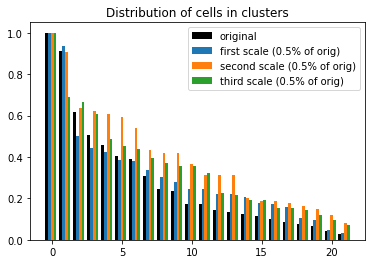

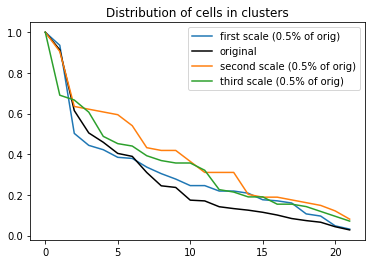

In [14]:
orig_clustercount  = adata.obs["louv_05"].value_counts()
orig_clustercount /= np.max(orig_clustercount)

humap_clustercount = adata_humap_sub.obs["louv_05"].value_counts()
humap_clustercount /= np.max(humap_clustercount)

humap2_clustercount = adata_humap2_sub.obs["louv_05"].value_counts()
humap2_clustercount /= np.max(humap2_clustercount)

humap3_clustercount = adata_humap3_sub.obs["louv_05"].value_counts()
humap3_clustercount /= np.max(humap3_clustercount)

barwidth = 0.2
plt.bar(np.arange(orig_clustercount.count())-2*barwidth, orig_clustercount, barwidth, label="original", color="black")
plt.bar(np.arange(humap_clustercount.count())-barwidth, humap_clustercount, barwidth , label=f"first scale ({subsampling_factor*100}% of orig)")
plt.bar(np.arange(humap2_clustercount.count()), humap2_clustercount, barwidth, label=f"second scale ({subsampling_factor*100}% of orig)")
plt.bar(np.arange(humap3_clustercount.count())+barwidth, humap3_clustercount, barwidth, label=f"third scale ({subsampling_factor*100}% of orig)")
plt.legend()
plt.title("Distribution of cells in clusters")
plt.show()

plt.plot(np.arange(humap_clustercount.count()), humap_clustercount , label=f"first scale ({subsampling_factor*100}% of orig)")
plt.plot(np.arange(orig_clustercount.count()), orig_clustercount, label="original", color="black")
plt.plot(np.arange(humap2_clustercount.count()), humap2_clustercount, label=f"second scale ({subsampling_factor*100}% of orig)")
plt.plot(np.arange(humap3_clustercount.count()), humap3_clustercount, label=f"third scale ({subsampling_factor*100}% of orig)")
plt.legend()
plt.title("Distribution of cells in clusters")
plt.show()

In [15]:
# sehr wenig zellen


**HSNE alt vs HSNE neu**

In [16]:
#hsne_tl.hsne(adata_humap_sub, verbose=True)
#hsne_pl.hsne(adata_humap_sub)